In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [74]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import torchvision
import numpy as np
from matplotlib import pyplot
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from PIL import Image
from collections import Counter

import sys
sys.path.append("../src/")
import model
import dataset
import config
from utils.function import init_logging, init_environment, preprocess_image,\
         recreate_image, get_lr, save_image

In [8]:
# hyper parameter
resume = "008-147"
#model_dir = "/data15/jiaxin/Interpretation/saved/models"
model_dir = "/media/lincolnzjx/Disk21/interpretation/saved/models"
generated_dir = "/media/lincolnzjx/Disk21/interpretation/saved/generated/"
backbone = "vgg16"
#generated_dir = 
#selected_layer = configs_dict["selected_layer"]
#selected_filter = configs_dict["selected_filter"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# model
net = model.Network(backbone=backbone, num_classes=200)
net.to(device)

Network(
  (model): VGG16(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [12]:
# resume from model
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path)
net.load_state_dict(ckpt) 

Resume from model from exp: 008 at epoch 147


<All keys matched successfully>

In [13]:
for name, param in net.named_parameters():
    print(name, param.size())

model.features.0.weight torch.Size([64, 3, 3, 3])
model.features.0.bias torch.Size([64])
model.features.2.weight torch.Size([64, 64, 3, 3])
model.features.2.bias torch.Size([64])
model.features.5.weight torch.Size([128, 64, 3, 3])
model.features.5.bias torch.Size([128])
model.features.7.weight torch.Size([128, 128, 3, 3])
model.features.7.bias torch.Size([128])
model.features.10.weight torch.Size([256, 128, 3, 3])
model.features.10.bias torch.Size([256])
model.features.12.weight torch.Size([256, 256, 3, 3])
model.features.12.bias torch.Size([256])
model.features.14.weight torch.Size([256, 256, 3, 3])
model.features.14.bias torch.Size([256])
model.features.17.weight torch.Size([512, 256, 3, 3])
model.features.17.bias torch.Size([512])
model.features.19.weight torch.Size([512, 512, 3, 3])
model.features.19.bias torch.Size([512])
model.features.21.weight torch.Size([512, 512, 3, 3])
model.features.21.bias torch.Size([512])
model.features.24.weight torch.Size([512, 512, 3, 3])
model.featur

In [52]:
for index, layer in enumerate(net.model.features):
    print(index, layer)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 ReLU(inplace=True)
19 Conv2d(512, 512, kernel_size=(3, 3)

In [15]:
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
def visualize_filters(filters, n_filters, n_channels):
    """Visualize filters. 
    
    """
    index = 1
    # get the feature map of specify channels
    for row in range(n_filters):
        fs = filters[:, :, :, row]
        for col in range(n_channels):
            # specify subplot and turn off axis
            ax = pyplot.subplot(n_filters, n_channels, index)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in gray scale
            pyplot.imshow(fs[:, :, col], cmap="gray")
            index += 1
    # show the figure
    pyplot.show()

In [33]:
def visualize_features_map(img_index, features_map, n_filters, n_channels):
    """Visulize feature map.
    """
    index = 1
    features_map = features_map.transpose((0, 2, 3, 1))
    for _ in range(n_filters):
        for _ in range(n_channels):
            # specify subplot and turn off axis
            ax = pyplot.subplot(n_filters, n_channels, index)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot feature maps in grayscale
            pyplot.imshow(features_map[img_index, :, :, index-1], cmap="gray")
            index += 1
    # show figure
    pyplot.show()

In [34]:
def obtain_features_map(image, model, conv_output_indexes=None):
    """Obtain feature map
    """
    results = []
    conv_output = []
    out = image
    for index, layer in enumerate(model):
        out = layer(out)
        if index in conv_output_indexes:
            conv_output.append(out.cpu().detach().numpy())
            print(index, out.size()) 
    return conv_output

In [77]:
# Load data
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] 
reverse_mean = [-0.485, -0.456, -0.406]
reverse_std = [1/0.229, 1/0.224, 1/0.225] 
train_transform = None
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    # transforms.RandomCrop(input_size),                                                                                                                              
    # transforms.RandomHorizontalFlip(),                                                                                                                              
    # transforms.ColorJitter(brightness=0.4, saturation=0.4, hue=0.4),                                                                                                
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = dataset.CUB(root="../data/", is_train=True, transform=train_transform)

trainset.set_data([1], 30)
#image, label, imgs_path = trainset
imgs_path = []                                                                                                                                                            
images = []
labels = []
for img, label, img_path in trainset:                                                                                                                                     
    images.append(img.unsqueeze(0))                                                                                                                                       
    labels.append(label)                                                                                                                                                  
    imgs_path.append(img_path)  

Len of new dataset is :30


In [78]:
#processed_image = preprocess_image(image, mean=mean, std=std, resize_im=True, resize=28, device=device)
#original_image = processed_image.clone().detach()
imgs_path

['../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0003_1033.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0044_784.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0050_870.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0071_792.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0081_800.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0065_809.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0061_563.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0085_564.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0005_565.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0055_570.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0025_571.jpg',
 '../data/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0092_834.jpg',
 '.

In [79]:
original_image = torch.cat(images, dim=0).to(device)

In [80]:
# hyper parameter
conv_output_indexes = [1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29]

In [81]:
conv_output = obtain_features_map(original_image, net.model.features, conv_output_indexes=conv_output_indexes)

1 torch.Size([30, 64, 224, 224])
3 torch.Size([30, 64, 224, 224])
6 torch.Size([30, 128, 112, 112])
8 torch.Size([30, 128, 112, 112])
11 torch.Size([30, 256, 56, 56])
13 torch.Size([30, 256, 56, 56])
15 torch.Size([30, 256, 56, 56])
18 torch.Size([30, 512, 28, 28])
20 torch.Size([30, 512, 28, 28])
22 torch.Size([30, 512, 28, 28])
25 torch.Size([30, 512, 14, 14])
27 torch.Size([30, 512, 14, 14])
29 torch.Size([30, 512, 14, 14])


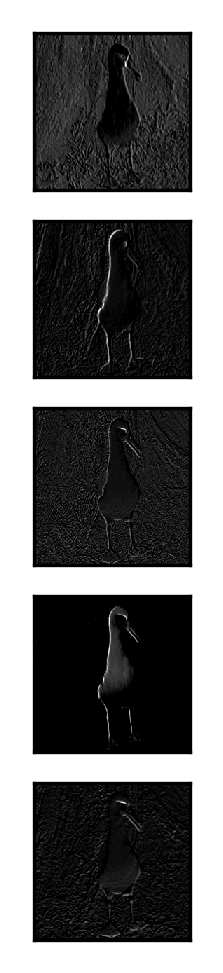

In [59]:
visualize_features_map(0, conv_output[0], n_filters=5, n_channels=1)

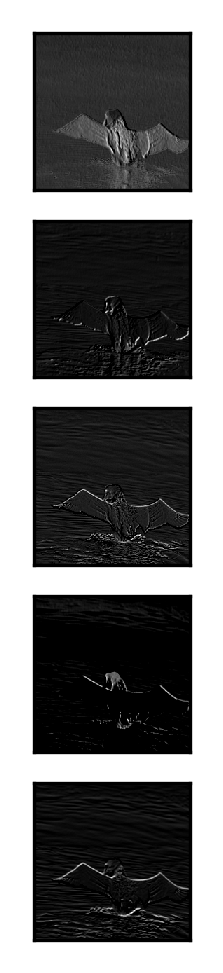

In [61]:
visualize_features_map(1, conv_output[0], n_filters=5, n_channels=1)

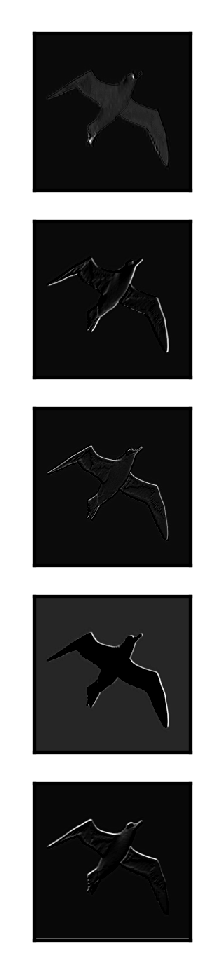

In [62]:
visualize_features_map(2, conv_output[0], n_filters=5, n_channels=1)

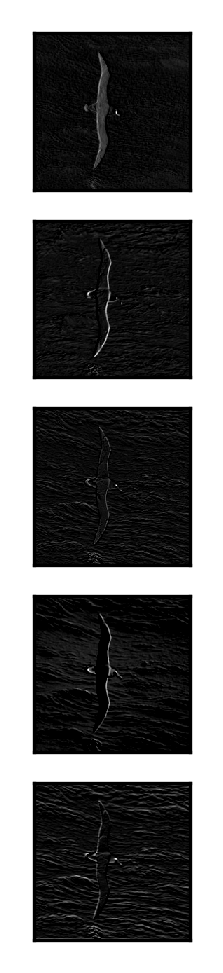

In [63]:
visualize_features_map(3, conv_output[0], n_filters=5, n_channels=1)

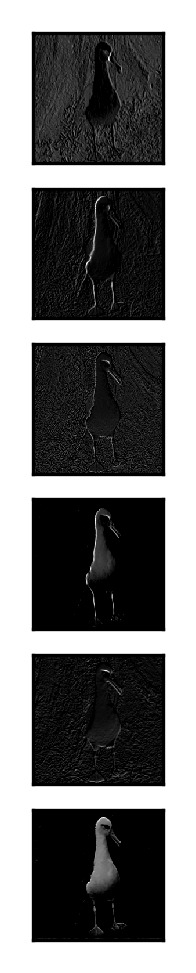

In [108]:
# layer 0 with filter 3
visualize_features_map(0, conv_output[0], n_filters=6, n_channels=1)

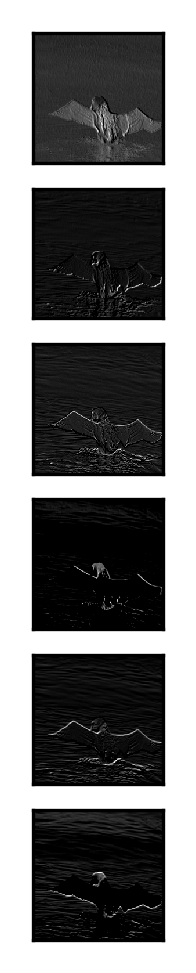

In [110]:
visualize_features_map(1, conv_output[0], n_filters=6, n_channels=1)

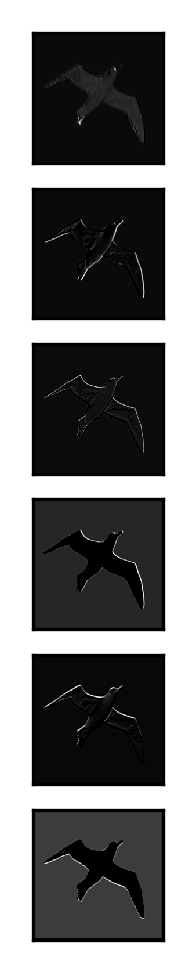

In [112]:
visualize_features_map(2, conv_output[0], n_filters=6, n_channels=1)

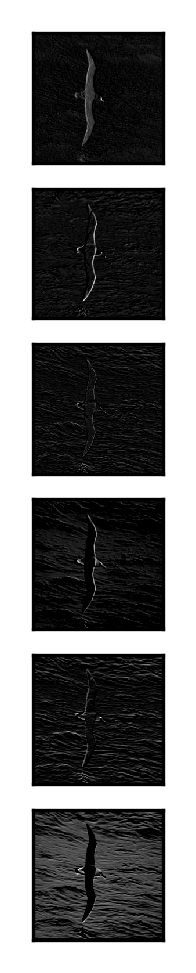

In [113]:
visualize_features_map(3, conv_output[0], n_filters=6, n_channels=1)

In [91]:
def find_max_activation_v1(img_index, conv_output):
    """Find thr max activation and return its index.
    
    Args:
        conv_output: (1, channel, height, width)
        
    Returns:
        max_index(int): 
    """
    conv_output = np.squeeze(conv_output[img_index])
    (channel, height, width) = conv_output.shape
    conv_output = np.reshape(conv_output, (channel, height * width))
    max_value = np.argmax(conv_output, axis=1)
    max_conv_index = np.argmax(max_value)
    return max_conv_index

In [101]:
def find_max_activation_v2(img_index, conv_output):
    """Find thr max activation and return its index. 
    Average over non zero pixels
    
    Args:
        conv_output: (1, channel, height, width)
        
    Returns:
        max_index(int): 
    """
    conv_output = np.squeeze(conv_output[img_index])
    (channel, height, width) = conv_output.shape
    conv_output = np.reshape(conv_output, (channel, height * width))
    # mean value over non zero pixels
    conv_output_mean_row = np.true_divide(conv_output.sum(axis=1), (conv_output != 0).sum(axis=1))
#    print(conv_output_mean_row)
    max_conv_index = np.argmax(conv_output_mean_row)
    return max_conv_index

In [105]:
# Iterate print out max filter for each images in same layer using find_max_activation_v1
for layer in range(len(conv_output_indexes)):
    print("Layer: {} ".format(layer))
    counter = Counter() 
    for index in range(len(imgs_path)):
        max_filter = find_max_activation_v1(index, conv_output[layer])
        counter.update([max_filter]) 
        # print(max_filter)
    print(counter)
    print("-"*80)

Layer: 0 
Counter({12: 7, 32: 4, 61: 4, 11: 2, 52: 2, 39: 1, 53: 1, 15: 1, 51: 1, 34: 1, 9: 1, 50: 1, 23: 1, 26: 1, 60: 1, 13: 1})
--------------------------------------------------------------------------------
Layer: 1 
Counter({3: 4, 56: 3, 19: 2, 36: 2, 12: 2, 46: 2, 28: 2, 8: 2, 11: 1, 35: 1, 4: 1, 55: 1, 58: 1, 20: 1, 60: 1, 9: 1, 26: 1, 47: 1, 40: 1})
--------------------------------------------------------------------------------
Layer: 2 
Counter({77: 15, 9: 3, 96: 1, 91: 1, 114: 1, 30: 1, 105: 1, 87: 1, 106: 1, 49: 1, 80: 1, 81: 1, 20: 1, 44: 1})
--------------------------------------------------------------------------------
Layer: 3 
Counter({127: 9, 6: 6, 75: 3, 103: 2, 74: 1, 73: 1, 116: 1, 14: 1, 25: 1, 24: 1, 91: 1, 113: 1, 86: 1, 102: 1})
--------------------------------------------------------------------------------
Layer: 4 
Counter({210: 4, 59: 3, 15: 3, 187: 3, 30: 2, 71: 2, 202: 1, 10: 1, 217: 1, 79: 1, 6: 1, 97: 1, 70: 1, 165: 1, 254: 1, 147: 1, 246: 1, 90: 1, 8

In [103]:
# Iterate print out max filter for each images in same layer using find_max_activation_v2
for layer in range(len(conv_output_indexes)):
    print("Layer: {} ".format(layer))
    counter = Counter() 
    for index in range(len(imgs_path)):
        max_filter = find_max_activation_v2(index, conv_output[layer])
        counter.update([max_filter]) 
        # print(max_filter)
    print(counter)
    print("-"*80)

Layer: 0 
Counter({12: 7, 32: 4, 61: 4, 11: 2, 52: 2, 39: 1, 53: 1, 15: 1, 51: 1, 34: 1, 9: 1, 50: 1, 23: 1, 26: 1, 60: 1, 13: 1})
--------------------------------------------------------------------------------
Layer: 1 
Counter({3: 4, 56: 3, 19: 2, 36: 2, 12: 2, 46: 2, 28: 2, 8: 2, 11: 1, 35: 1, 4: 1, 55: 1, 58: 1, 20: 1, 60: 1, 9: 1, 26: 1, 47: 1, 40: 1})
--------------------------------------------------------------------------------
Layer: 2 
Counter({77: 15, 9: 3, 96: 1, 91: 1, 114: 1, 30: 1, 105: 1, 87: 1, 106: 1, 49: 1, 80: 1, 81: 1, 20: 1, 44: 1})
--------------------------------------------------------------------------------
Layer: 3 
Counter({127: 9, 6: 6, 75: 3, 103: 2, 74: 1, 73: 1, 116: 1, 14: 1, 25: 1, 24: 1, 91: 1, 113: 1, 86: 1, 102: 1})
--------------------------------------------------------------------------------
Layer: 4 
Counter({210: 4, 59: 3, 15: 3, 187: 3, 30: 2, 71: 2, 202: 1, 10: 1, 217: 1, 79: 1, 6: 1, 97: 1, 70: 1, 165: 1, 254: 1, 147: 1, 246: 1, 90: 1, 8

In [59]:
# Visualize image value

generated_path = os.path.join(generated_dir, "105")
print(generated_path)

def convert_file_name(file):
    return int(file.split(".")[0])

result = sorted(list(os.listdir(generated_path)), reverse=True, key=convert_file_name)[0]
result = os.path.join(generated_path, result)
print(result)

image = Image.open(result)
print(np.array(image))

/media/lincolnzjx/Disk21/interpretation/saved/generated/105
/media/lincolnzjx/Disk21/interpretation/saved/generated/105/19900.jpg
[[ 65   9   0   6  12 184   0   3 217 249  10   0   4 226 255   0   4   2
  255 255   0 168   1  74  95 137   6  16]
 [ 36  57   5  47   0 192  36   0  43 183  14  35   0 255  70  12  11 134
  208   0 249  11 184   9   0  10   0   0]
 [ 83  32   1   0  32  71   0  73 255   5  10 119 178 157 166   0  70 120
  168  95  14   0 172   0 255   4  74   7]
 [ 33 141   0  22  86 150   0 147  52  63   5   0   0  78   0  23   0  96
    0   0   0 165   1 255   0 173   0 248]
 [114   0 211   0   0   9   0 158   3 127 236   0 195 229   0   8 255   0
  255  39 138   0   7 244  11   0 206 255]
 [ 83  19 104   0  21 142   0 205   3   5   5   7   0  67  11 141   0 160
    0   0   0  27 108   9  20  15 223 255]
 [245  21 232   2   0  57 141   0 190 254   0 217 121   0 207   0  19 253
    5   0 156   0   0 248   9 255   0 237]
 [182   0  11 231   0  10 109   0  11  46  30   0 2